## Introduction

This notebook showcases both the use of notebooks in data exploration, and the use of Iris for reading and analysing datasets.
Sections are somewhat lengthy, because it showcases the data exploration part, where a user will want to examine the various variables and results. A shorter version is available for a very quick overview of analysing datasets with Jupyter notebooks.

## Reading the data from URLs

Iris can read from filenames or URLs, when files are served from an OpenDAP server. The `iris.load()` utility function takes a path or URL and will load the dataset lazily: it only reads the actual data when it's needed. This saves the memory and time overhead when there are multiple datasets inside a file and not all need to be used.

But neither Iris nor netCDF4 can read directly from a URL if the file is not hosted by an OpenDAP server (which includes, for example, ftp sites).
Since Iris also can't read a binary stream (file object), we are forced to first download the file, then save it to a temporary file, then read from that file. Note that the latter temporary file is still lazily loaded, though we had to download the full file over the internet.

In [1]:
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
import iris

Note that `iris.load()` returns a list of cubes, a `CubeList`, not a single cube. In case of a single datacube inside the file, that would result in a one-element list. In this case, there are two cubes, although the latter one is of less interest for the actual figure we'll make.

In [2]:
url = 'https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT.4.6.0.0.median.nc'
with urlopen(url) as stream, NamedTemporaryFile(delete=False, suffix=".nc") as fp:
    fp.write(stream.read())
    cubes = iris.load(fp.name)
cubes

[<iris 'Cube' of near_surface_temperature_anomaly / (K) (time: 2030; latitude: 36; longitude: 72)>,
<iris 'Cube' of field_status / (1) (time: 2030; -- : 1)>]

A slight disadvantage of the temporary file is that it may not get cleaned up immediately after we stop using the file. In fact, with Iris's lazy loading, we have to keep the file around until we're completely done with the data, hence the argument `delete=False`.  
But each time we run the above cell, we create a new temporary file, and we may end up with a lot of temporary files containing the same data, taking up a lot of disk space. It is then more logical to just save the data to a specific named file, and use that all the time. For this demonstration, we use the temporary file option.

Since the above code can be annoying enough to remember, a small utility function `fetch` has been created; it needs to be imported from the `eucp` module. The `fetch` function takes a filepath or URI as first argument, and an optional `path` argument as the second argument: if `path` is set, it will be the location of the output file. If it's not set, a temporary file, like above, is created. If `path` is a directory, the filename is deduced from the URI and the file is created in that directory. Let's use the latter option with a newly created directory:

In [3]:
import os
os.makedirs('datafiles', exist_ok=True)

You should see the directory appear in the browser area of the notebook. Let's download and save the dataset:

In [4]:
url = 'https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT.4.6.0.0.median.nc'
#url = 'datafiles/HadCRUT.4.6.0.0.median.nc'   # Use this for faster loading after the first download
import eucp
cubes = eucp.fetch(url, 'datafiles')
cubes

[<iris 'Cube' of near_surface_temperature_anomaly / (K) (time: 2030; latitude: 36; longitude: 72)>,
<iris 'Cube' of field_status / (1) (time: 2030; -- : 1)>]

## Examining the data

Iris doesn't order the list of cubes returned, so we'll first make sure they are in the order we want them (so that this notebook is consistent).

In [5]:
if cubes[0].name() == "field_status":
    cubes = cubes[::-1]
cubes

[<iris 'Cube' of near_surface_temperature_anomaly / (K) (time: 2030; latitude: 36; longitude: 72)>,
<iris 'Cube' of field_status / (1) (time: 2030; -- : 1)>]

Let's examine the first cube. Iris provides a nice representation in notebooks:

In [6]:
cubes[0]

<iris 'Cube' of near_surface_temperature_anomaly / (K) (time: 2030; latitude: 36; longitude: 72)>

And the second cube (which we'll discard later on):

In [7]:
cubes[1]

<iris 'Cube' of field_status / (1) (time: 2030; -- : 1)>

Out of curiosity, what is precisely in that second cube?
Let's look at the unique data values.

In [8]:
import numpy as np
np.unique(cubes[1].data), np.unique(cubes[1].data.data[:-20])

(masked_array(data=[b'f', b'p'],
              mask=False,
        fill_value=b'N',
             dtype='|S1'), array([b'f'], dtype='|S1'))

A set of 2030 'f' and 'p' single characters, relating to the time coordinate, with 'p' values only at the end of the array. Presumably related to the validation or verification of the data.

Let's have a look at the coordinates of the first dataset:

In [9]:
cube1 = cubes[0]
cube1.coords()

[DimCoord(array([1.55000e+01, 4.50000e+01, 7.45000e+01, ..., 6.17105e+04,
        6.17415e+04, 6.17710e+04], dtype=float32), standard_name='time', units=Unit('days since 1850-1-1 00:00:00', calendar='gregorian'), long_name='time', var_name='time', attributes={'end_month': 2, 'end_year': 2019, 'start_month': 1, 'start_year': 1850}),
 DimCoord(array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5,
        -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,
          2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
         47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5],
       dtype=float32), standard_name='latitude', units=Unit('degrees'), long_name='latitude', var_name='latitude', attributes={'point_spacing': 'even'}),
 DimCoord(array([-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5, -142.5,
        -137.5, -132.5, -127.5, -122.5, -117.5, -112.5, -107.5, -102.5,
         -97.5,  -92.5,  -87.5,  -82.5,  -77.5,  -72.5,  -67.5,  

## Fixing the dimensions

The coordinates are missing bounds, which we'll want to use later on, when averaging over the area.
Iris has a utility function that allows it to guess the bounds from the grid, which in this case will work well, since it's a very regular grid.
Note that in the cell below, a few lines have been commented out:
- when bounds exists (previously guessed or not), Iris will not allow someone to override the bounds. You'll have to explicitly set the bounds to `None` before you can guess the bounds again. So when running the cell multiple times, the first three lines will need to be uncommented to avoid errors.
- the counds consist of two dimensional NumPy arrays. The way (and shape of the arrays) these are printed by default causes lengthy outputs. to avoid that, I've commented out the last line, but feel free to uncoment and see what the guessed bounds are.

In [10]:
#cube1.coord('time').bounds = None
#cube1.coord('latitude').bounds = None
#cube1.coord('longitude').bounds = None
cube1.coord('time').guess_bounds()
cube1.coord('latitude').guess_bounds()
cube1.coord('longitude').guess_bounds()
#cube1.coord('latitude'), cube1.coord('longitude'), cube.coord('time')

## Reading the other datasets

Before proceeding with the analysis, let's read the other datasets of interest.

In [11]:
url = 'ftp://ftp.cdc.noaa.gov/Datasets/noaaglobaltemp/air.mon.anom.nc'
#url = 'datafiles/air.mon.anom.nc'   # Use this for faster loading after the first download
cubes = eucp.fetch(url, 'datafiles')
cubes

/opt/conda/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'air' contains unknown cell method 'anomaly'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)
/opt/conda/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2036: UserWarning: Gracefully filling 'time' dimension coordinate masked bounds
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/opt/conda/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2076: UserWarning: Failed to create 'time' dimension coordinate: The bounds array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))


[<iris 'Cube' of air_temperature_anomaly / (degC) (-- : 1671; latitude: 36; longitude: 72)>]

There is only one cube of interest in this list; let's examine that cube

In [12]:
cube2 = cubes[0]
cube2

<iris 'Cube' of air_temperature_anomaly / (degC) (-- : 1671; latitude: 36; longitude: 72)>

Note that the time coordinate is an auxiliary coordinate; let's have a closer look

In [13]:
cube2.coord('time')

AuxCoord(array([29219., 29250., 29279., ..., 79988., 80019., 80047.]), bounds=array([[9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36],
       ...,
       [9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36],
       [9.96920997e+36, 9.96920997e+36]]), standard_name='time', units=Unit('days since 1800-1-1 00:00:0.0', calendar='gregorian'), long_name='Time', var_name='time', attributes={'actual_range': array([29219., 80047.]), 'avg_period': '0000-01-00 00:00:00', 'coordinate_defines': 'start', 'delta_t': '0000-01-00 00:00:00'})

The bounds for the time coordinate are all off. These look like fill values, and the original input had masked bounds.
Let guess the proper bounds.

In [14]:
cube2.coord('time').bounds = None
cube2.coord('time').guess_bounds()

Once the bounds are fixed, we can make the time coordinate a proper dimension coordinate. Iris has a utility function to upgrade an auxiliary coordinate to a dimension coordinate.

In [15]:
iris.util.promote_aux_coord_to_dim_coord(cube2, 'time')
cube2.coord('time')

DimCoord(array([29219., 29250., 29279., ..., 79988., 80019., 80047.]), bounds=array([[29203.5, 29234.5],
       [29234.5, 29264.5],
       [29264.5, 29294.5],
       ...,
       [79972.5, 80003.5],
       [80003.5, 80033. ],
       [80033. , 80061. ]]), standard_name='time', units=Unit('days since 1800-1-1 00:00:0.0', calendar='gregorian'), long_name='Time', var_name='time', attributes={'actual_range': array([29219., 80047.]), 'avg_period': '0000-01-00 00:00:00', 'coordinate_defines': 'start', 'delta_t': '0000-01-00 00:00:00'})

Much better. Let's update the bounds for the longitude and latitude as well.

In [16]:
#cube2.coord('latitude').bounds = None
#cube2.coord('longitude').bounds = None
cube2.coord('latitude').guess_bounds()
cube2.coord('longitude').guess_bounds()
#cube2.coord('latitude'), cube2.coord('longitude')

The same procecure for the last dataset: load it, select the right cube, and fix the coordinates as necessary

In [17]:
url = 'ftp://ftp.cdc.noaa.gov/Datasets/gistemp/landonly/250km/air.2x2.250.mon.anom.land.nc'
#url = 'datafiles/air.2x2.250.mon.anom.land.nc'      # Use this for faster loading after the first download
cubes = eucp.fetch(url, 'datafiles')
cubes

/opt/conda/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'air' contains unknown cell method 'anomaly'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


[<iris 'Cube' of air_temperature_anomaly / (degC) (time: 1671; latitude: 90; longitude: 180)>]

In [18]:
cube3 = cubes[0]

In [19]:
cube3.coords()

[DimCoord(array([29219., 29250., 29279., ..., 79988., 80019., 80047.]), standard_name='time', units=Unit('days since 1800-1-1 00:00:00', calendar='gregorian'), long_name='Time', var_name='time', attributes={'actual_range': array([29219., 80047.]), 'avg_period': '0000-01-00 00:00:00', 'delta_t': '0000-01-00 00:00:00'}),
 DimCoord(array([ 89.,  87.,  85.,  83.,  81.,  79.,  77.,  75.,  73.,  71.,  69.,
         67.,  65.,  63.,  61.,  59.,  57.,  55.,  53.,  51.,  49.,  47.,
         45.,  43.,  41.,  39.,  37.,  35.,  33.,  31.,  29.,  27.,  25.,
         23.,  21.,  19.,  17.,  15.,  13.,  11.,   9.,   7.,   5.,   3.,
          1.,  -1.,  -3.,  -5.,  -7.,  -9., -11., -13., -15., -17., -19.,
        -21., -23., -25., -27., -29., -31., -33., -35., -37., -39., -41.,
        -43., -45., -47., -49., -51., -53., -55., -57., -59., -61., -63.,
        -65., -67., -69., -71., -73., -75., -77., -79., -81., -83., -85.,
        -87., -89.], dtype=float32), standard_name='latitude', units=Unit('deg

In [20]:
#cube3.coord('latitude').bounds = None
#cube3.coord('longitude').bounds = None
cube3.coord('latitude').guess_bounds()
cube3.coord('longitude').guess_bounds()
#cube3.coord('latitude'), cube2.coord('longitude')

We'll put all three cubes into a list; (or a set, since order doesn't really matter).
Iris has a `CubeList`, but since we'll not use any of the specific functionality of a `CubeList`, we'll just use a normal list

In [21]:
cubes = [cube1, cube2, cube3]
cubes

[<iris 'Cube' of near_surface_temperature_anomaly / (K) (time: 2030; latitude: 36; longitude: 72)>,
 <iris 'Cube' of air_temperature_anomaly / (degC) (time: 1671; latitude: 36; longitude: 72)>,
 <iris 'Cube' of air_temperature_anomaly / (degC) (time: 1671; latitude: 90; longitude: 180)>]

## Calculating the global mean

To calculate the global mean temperature, we "collapse" the cube over latitude and longitude, using the mean function, and with area weights applied. The area weights need to be calculated separately for each cube, and are obtained from the latitude and longitude bounds.

In [22]:
means = []
for cube in cubes:
    weights = iris.analysis.cartography.area_weights(cube)
    mean = cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN, weights=weights)
    means.append(mean)
means

/opt/conda/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


[<iris 'Cube' of near_surface_temperature_anomaly / (K) (time: 2030)>,
 <iris 'Cube' of air_temperature_anomaly / (degC) (time: 1671)>,
 <iris 'Cube' of air_temperature_anomaly / (degC) (time: 1671)>]

Each mean is still an Iris cube, with all relevant meta information. The dimensions are obviously reduced to just time; let's look at one cube

In [23]:
means[0]

Near Surface Temperature Anomaly (K),time
Shape,2030
Dimension coordinates,
time,x
Scalar coordinates,
latitude,"0.0 degrees, bound=(-90.0, 90.0) degrees"
longitude,"0.0 degrees, bound=(-180.0, 180.0) degrees"
Attributes,
Conventions,CF-1.0
comment,
ensemble_member_index,0


## Plotting the global means

Let's plot the three, now one-dimensional, datasets. Matplotlib is the default plotting package, with an easy to use interface through its module Pyplot. Iris provides its own plotting plotting module, which is essentially a wrapper around Matplotlib/Pyplot, that can handle Iris cubes directly.

With notebooks, we can use the so-called 'magic" command `%matplotlib inline` to let Jupyter render the figure directly in-place: no need to save it to a file or anything, it will just appears directly below the cell once executed. That's great for interactive exploration.

We just loop through the three averaged datasets and plot them on top of each other.

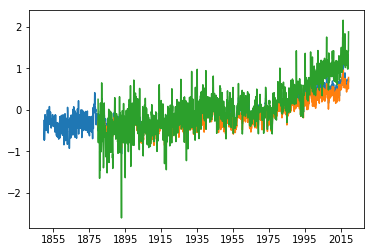

In [24]:
import iris.plot as iplt
import matplotlib.pyplot as plt
%matplotlib inline

for mean in means:
    iplt.plot(mean)

## Calculating a zeropoint for the datasets

The monthly resolution is a bit too much, certainly over the relevant timespan. We'll fix that later, but we'll first account for the fact that the three datasets may not have the same zeropoint. Here, we'll use the 1961 to 1990 date range to calculate an average zeropoint for each dataset individually.

We can use plain Python `datetime.datetime` objects to start with: Iris will handle this properly behind the scenes, since it knows the unit of the various time coordinates. We use an `iris.Constraint`, which can take a function that will be applied to any point of the relevant coordinate to filter it.  
`lambda` is Python's way to create a quick, anonymous function. For those not familiar with it: read it as

        def anonymous_function(cell): 
            return start <= cell.point <= stop

In [25]:
from datetime import datetime
start = datetime(1961, 1, 1)
stop = datetime(1990, 12, 31)
timespan = iris.Constraint(time=lambda cell: start <= cell.point <= stop)

Now loop over the means, extracting the relevant timespan, and then averaging that timespan (collapsing with a mean). Since `mean.extract` returns another cube, we can chain the two operations.

In [26]:
zeropoints = []
for mean in means:
    zeropoint = mean.extract(timespan).collapsed('time', iris.analysis.MEAN)
    zeropoints.append(zeropoint)
zeropoints

/opt/conda/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


[<iris 'Cube' of near_surface_temperature_anomaly / (K) (scalar cube)>,
 <iris 'Cube' of air_temperature_anomaly / (degC) (scalar cube)>,
 <iris 'Cube' of air_temperature_anomaly / (degC) (scalar cube)>]

There'll be a warning that that the averaging happened over a non-contiguous coordinate. Presumably, there is the occasional gaps in the time coordinate, and the time bounds don't fully cover the timespan. For ease, we assume that, overall, Iris did the right thing, and our zeropoint is correct.

Even the zeropoints, while scalars, are Iris cubes that include units and the full metadata:

In [27]:
zeropoints[0]

Near Surface Temperature Anomaly (K),(scalar cube)
Scalar coordinates,
latitude,"0.0 degrees, bound=(-90.0, 90.0) degrees"
longitude,"0.0 degrees, bound=(-180.0, 180.0) degrees"
time,"1976-01-01 12:00:00, bound=(1961-01-01 00:00:00, 1991-01-01 00:00:00)"
Attributes,
Conventions,CF-1.0
comment,
ensemble_member_index,0
ensemble_members,100
history,Updated at 25/03/2019 16:03:56


Instead of retrieving the actual data values, we can simply subtract one cube from the other: Iris handles this under the hood. Thus, for each dataset separately, we subtract the zeropoint.

In [28]:
zpmeans = []
for mean, zeropoint in zip(means, zeropoints):
    zpmeans.append(mean - zeropoint)

Subtracting a zeropoint has made a difference in the resulting plot

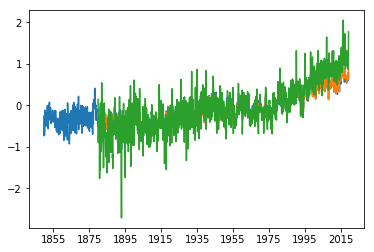

In [29]:
for zpmean in zpmeans:
    iplt.plot(zpmean)

## Calculating a rolling average

Let's smooth the data with a rolling average. For Iris, there is the `rolling_window` method of a cube that can be used. It takes an analyses method (again, here, the mean), and a size of the mean (I've picked 12 here, which is 12 months).

(Don't be deceived by the use of a list comprehension here: it is the same loop as before, written differently and shorter this time)

In [30]:
smootheds = [cube.rolling_window('time', iris.analysis.MEAN, 12) for cube in zpmeans]

/opt/conda/lib/python3.6/site-packages/iris/cube.py:3584: UserWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  'the rolling window operation.' % coord_.name())


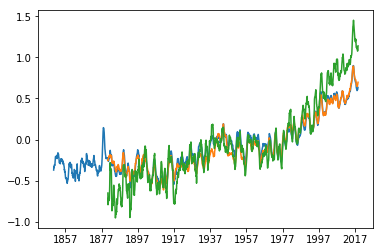

In [31]:
for smoothed in smootheds:
    iplt.plot(smoothed)

## Calculating seasonal and yearly averages

We can also calculate the seasonal and yearly averages. For this, we use the `aggregated_by` method on cubes, but we need to add two auxiliary coordinates to the datasets first: the season-year and year coordinates. We can use the `add_season` and `add_season_year` utility functions from the `iris.coord_categorisation` module (note: this module has to be loaded explicitly, unlike other modules, which are loaded automatically with `import iris`).

In [32]:
import iris.coord_categorisation
for cube in zpmeans:
    iris.coord_categorisation.add_season(cube, 'time', name='clim_season')
    iris.coord_categorisation.add_season_year(cube, 'time', name='season_year')
zpmeans[0]

Unknown (K),time
Shape,2030
Dimension coordinates,
time,x
Auxiliary coordinates,
clim_season,x
season_year,x
Scalar coordinates,
latitude,"0.0 degrees, bound=(-90.0, 90.0) degrees"
longitude,"0.0 degrees, bound=(-180.0, 180.0) degrees"


Calculate and plot the seasonal averages for each year.

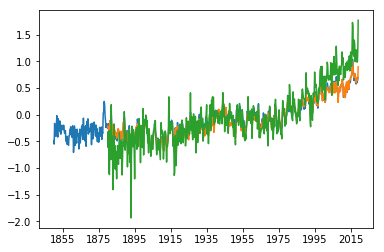

In [33]:
for cube in zpmeans:
    annual_seasonal_mean = cube.aggregated_by(['clim_season', 'season_year'], iris.analysis.MEAN)
    iplt.plot(annual_seasonal_mean)

That is actually only marginally better; let's try just the average temperature per year

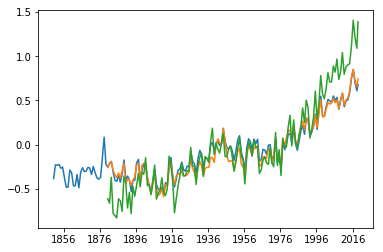

In [34]:
for cube in zpmeans:
    annual_seasonal_mean = cube.aggregated_by('season_year', iris.analysis.MEAN)  # ['season_year'] also works as argument
    iplt.plot(annual_seasonal_mean)